In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import clear_output
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from collections import defaultdict
import csv
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            
            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [4]:
transform = Compose([
    Resize((128, 192)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    # Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)

train_ans = pd.read_csv('human_poses_data/train_answers.csv')
targets = list(map(int, train_ans['target_feature'].values))

train_indices, valid_indices = train_test_split(
    range(len(train_data)),
    test_size=None,
    stratify=targets,
    random_state=42
)

# Создаем Subset'ы
train_set = Subset(train_data, train_indices)
# valid_set = Subset(train_data, valid_indices)
valid_loader = DataLoader(train_set, batch_size=128, shuffle=False)

def compute_stats_accurate(dataloader):
    channels = 3
    mean = 0.
    std = 0.
    nb_samples = 0.
    
    for images, _ in tqdm(dataloader):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.var(2).sum(0)
        nb_samples += batch_samples
    
    mean /= nb_samples
    std = torch.sqrt(std / nb_samples)
    
    print(mean, std)

compute_stats_accurate(valid_loader)

  0%|          | 0/73 [00:00<?, ?it/s]

100%|██████████| 73/73 [02:27<00:00,  2.01s/it]

tensor([0.4675, 0.4499, 0.4128]) tensor([0.2303, 0.2272, 0.2263])


In [4]:
transform = Compose([
    Resize((227, 340)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.4675, 0.4499, 0.4127), (0.2345, 0.2314, 0.2303)),
    # RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(train_data.le, f)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)

# Стратифицированное разделение
labels = [train_data.label_map[int(img_name.split('.')[0])] for img_name in train_data.image_files]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, valid_indices = next(splitter.split(np.zeros(len(labels)), labels))

train_set = torch.utils.data.Subset(train_data, train_indices)
valid_set = torch.utils.data.Subset(train_data, valid_indices)


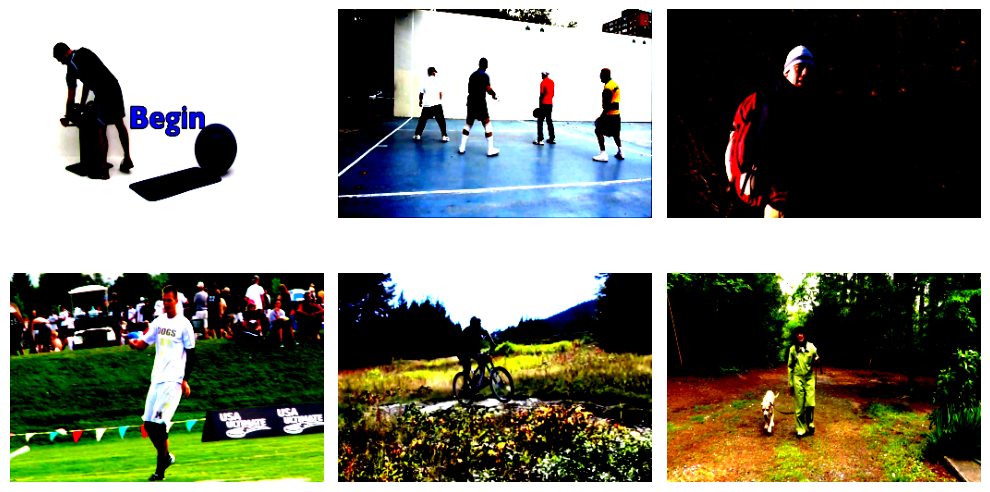

In [9]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_data, num_images=6)

In [5]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count <= 300:
                needed = current_count * 5
            elif current_count <= 400:
                needed = current_count * 3
            elif current_count <= 500:
                needed = current_count * 2
            elif current_count <= 1000:
                needed = current_count
            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = list(np.random.choice(self.augmentations, size=num_augs, replace=False))
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)

In [6]:
all_labels = [label for _, label in balanced_train_set]

# Вычисляем веса классов
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Преобразуем в тензор и отправляем на устройство
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Выведем информацию о распределении классов
unique, counts = np.unique(all_labels, return_counts=True)
print("Class distribution after balancing:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")
print("\nClass weights:", dict(zip(unique, class_weights.cpu().numpy())))

Class distribution after balancing:
Class 0: 2010 samples
Class 1: 648 samples
Class 2: 1272 samples
Class 3: 1344 samples
Class 4: 1204 samples
Class 5: 1572 samples
Class 6: 1280 samples
Class 7: 1278 samples
Class 8: 1956 samples
Class 9: 1248 samples
Class 10: 1266 samples
Class 11: 1500 samples
Class 12: 1416 samples
Class 13: 1092 samples
Class 14: 1204 samples
Class 15: 1312 samples

Class weights: {np.int64(0): np.float32(0.671704), np.int64(1): np.float32(2.0835261), np.int64(2): np.float32(1.061419), np.int64(3): np.float32(1.0045573), np.int64(4): np.float32(1.1213663), np.int64(5): np.float32(0.85885817), np.int64(6): np.float32(1.0547851), np.int64(7): np.float32(1.0564358), np.int64(8): np.float32(0.69024795), np.int64(9): np.float32(1.081831), np.int64(10): np.float32(1.0664494), np.int64(11): np.float32(0.90008336), np.int64(12): np.float32(0.9534781), np.int64(13): np.float32(1.2363782), np.int64(14): np.float32(1.1213663), np.int64(15): np.float32(1.0290587)}


Количество элементов по классам:
Класс 0: 2010 элементов
Класс 1: 108 элементов
Класс 2: 424 элементов
Класс 3: 1344 элементов
Класс 4: 602 элементов
Класс 5: 786 элементов
Класс 6: 640 элементов
Класс 7: 426 элементов
Класс 8: 978 элементов
Класс 9: 312 элементов
Класс 10: 422 элементов
Класс 11: 375 элементов
Класс 12: 354 элементов
Класс 13: 182 элементов
Класс 14: 602 элементов
Класс 15: 328 элементов


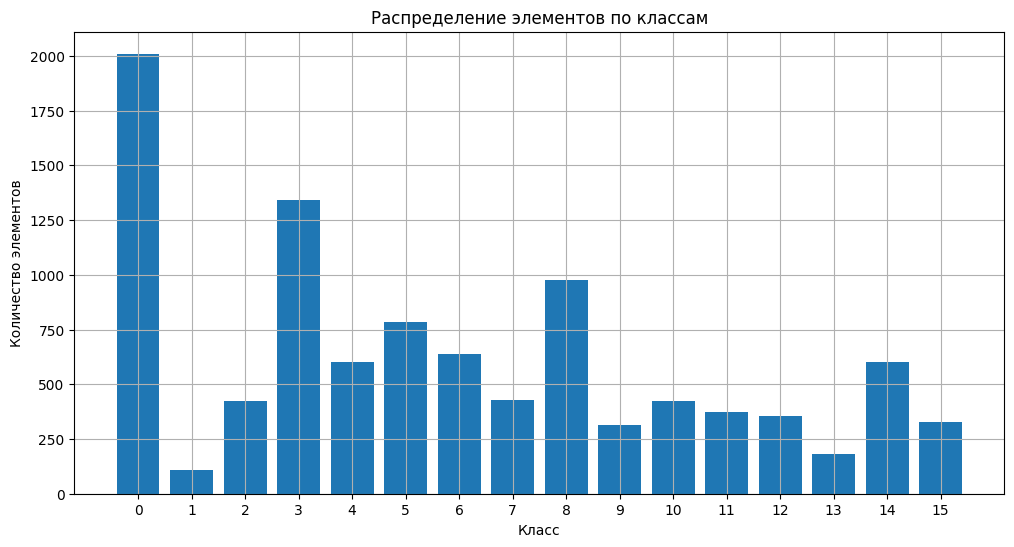

Количество элементов по классам:
Класс 0: 2010 элементов
Класс 1: 648 элементов
Класс 2: 1272 элементов
Класс 3: 1344 элементов
Класс 4: 1204 элементов
Класс 5: 1572 элементов
Класс 6: 1280 элементов
Класс 7: 1278 элементов
Класс 8: 1956 элементов
Класс 9: 1248 элементов
Класс 10: 1266 элементов
Класс 11: 1500 элементов
Класс 12: 1416 элементов
Класс 13: 1092 элементов
Класс 14: 1204 элементов
Класс 15: 1312 элементов


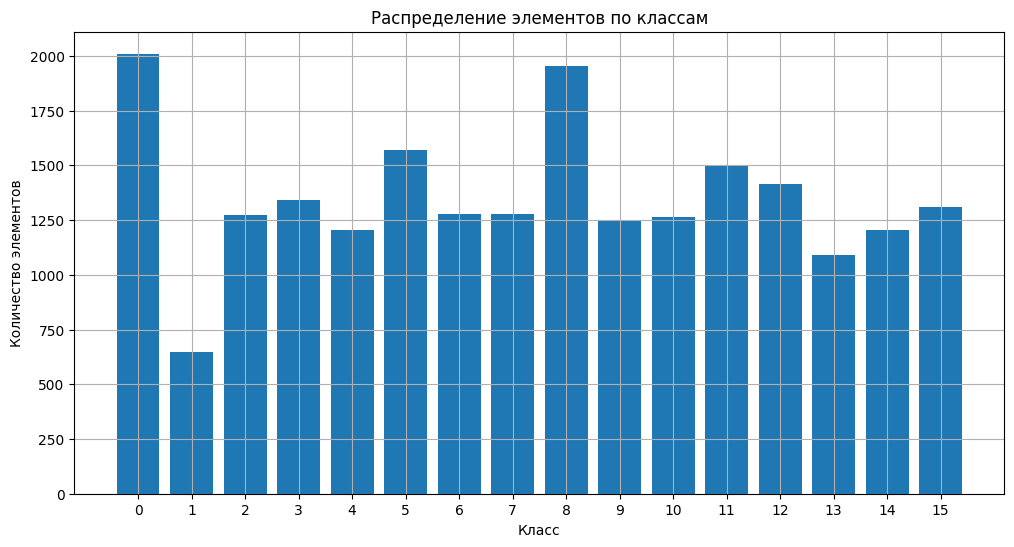

In [ ]:
def count_classes(dataset):
    class_counts = defaultdict(int)
    
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    print("Количество элементов по классам:")
    for class_id in sorted(class_counts.keys()):
        print(f"Класс {class_id}: {class_counts[class_id]} элементов")
    
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Класс')
    plt.ylabel('Количество элементов')
    plt.title('Распределение элементов по классам')
    plt.xticks(list(class_counts.keys()))
    plt.grid(True)
    plt.show()

class_counts = count_classes(train_set)
class_counts = count_classes(balanced_train_set)

In [7]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        scale = self.sigmoid(out).view(b, c, 1, 1)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        scale = self.sigmoid(self.conv(concat))
        return x * scale

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, use_attention=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
        
        self.use_attention = use_attention
        if use_attention:
            self.ca = ChannelAttention(out_channels)
            self.sa = SpatialAttention()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        
        if self.use_attention:
            out = self.ca(out)
            out = self.sa(out)

        return out

class HumanActivityModel(nn.Module):
    def __init__(self, num_classes=16):
        super(HumanActivityModel, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks with increasing feature maps
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Context aggregation
        self.context_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Final classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample, use_attention=True))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, use_attention=True))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Backbone
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Context aggregation
        x = self.context_conv(x)
        
        # Classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [10]:
model = HumanActivityModel().to(device)
summary(model, input_size=(3, 128, 128), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
AdaptiveAvgPool2d-11             [-1, 64, 1, 1]               0
           Linear-12                    [-1, 4]             260
             ReLU-13                    [-1, 4]               0
           Linear-14                   

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor

    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # Projections
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)  # (B, N, C')
        key = self.key(x).view(batch_size, -1, H * W)  # (B, C', N)
        value = self.value(x).view(batch_size, -1, H * W)  # (B, C, N)
        
        # Attention scores
        attention = torch.bmm(query, key)  # (B, N, N)
        attention = F.softmax(attention, dim=-1)
        
        # Apply attention to values
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, N)
        out = out.view(batch_size, C, H, W)
        
        # Learnable scaling + residual connection
        return self.gamma * out + x

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=16):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1 (227x340x3 -> 55x83x96)
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            # MaxPool (55x83x96 -> 27x41x96)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2 (27x41x96 -> 27x41x256)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            # MaxPool (27x41x256 -> 13x20x256)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv3 (13x20x256 -> 13x20x384)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            # Self-Attention after Conv3
            SelfAttention(384),
            
            # Conv4 (13x20x384 -> 13x20x384)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            # Self-Attention after Conv4
            SelfAttention(384),
            
            # Conv5 (13x20x384 -> 13x20x256)
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            # MaxPool (13x20x256 -> 6x9x256)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 9, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

In [10]:
model = AlexNet(num_classes=16).to(device)
summary(model, (3, 227, 340))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 83]          34,944
              ReLU-2           [-1, 96, 55, 83]               0
       BatchNorm2d-3           [-1, 96, 55, 83]             192
         MaxPool2d-4           [-1, 96, 27, 41]               0
            Conv2d-5          [-1, 256, 27, 41]         614,656
              ReLU-6          [-1, 256, 27, 41]               0
       BatchNorm2d-7          [-1, 256, 27, 41]             512
         MaxPool2d-8          [-1, 256, 13, 20]               0
            Conv2d-9          [-1, 384, 13, 20]         885,120
             ReLU-10          [-1, 384, 13, 20]               0
      BatchNorm2d-11          [-1, 384, 13, 20]             768
           Conv2d-12           [-1, 48, 13, 20]          18,480
           Conv2d-13           [-1, 48, 13, 20]          18,480
           Conv2d-14          [-1, 384,

In [11]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [12]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())

            
    avg_loss = total_loss / len(dataloader)
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1
    else:
        return avg_loss, None, None

In [13]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

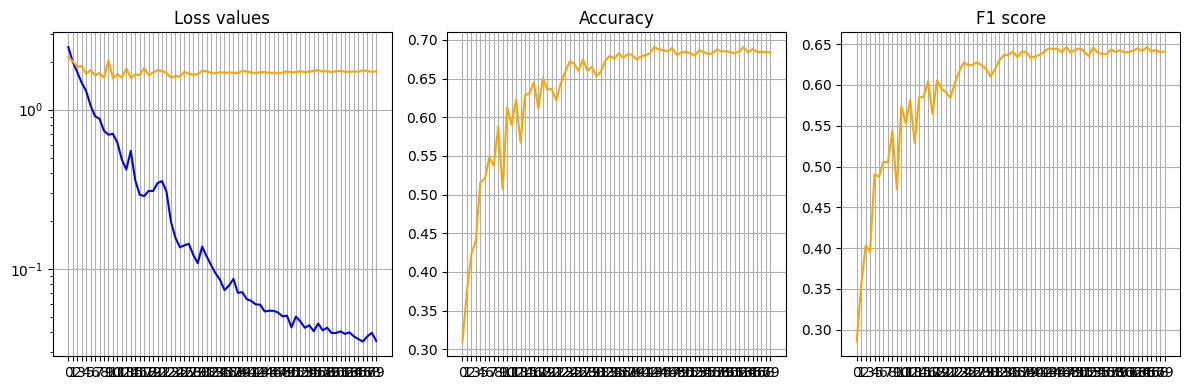

Current LR: 1.171875e-06
Min loss: 1.576480
Max Accuracy: 0.6908
Max F1: 0.6465


In [14]:
model = AlexNet(num_classes=16).to(device)
NUM_EPOCHS = 70

#loss_function = LabelSmoothingCrossEntropy(smoothing=0.1)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), 
                lr=3e-4,
                weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

best_f1 = 0

train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)
    
    scheduler.step(f1_)

    if f1_ > best_f1:
        best_f1 = f1_
        torch.save(model, 'AlexNet_with_Self-attention.pth')
        torch.save(model.state_dict(), 'AlexNet_with_Self-attention_weights.pth')
    
    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")


    

print(f"Min loss: {min(test_loss_hist):.6f}")
print(f"Max Accuracy: {max(accuracy):.4f}")
print(f"Max F1: {max(f1):.4f}")

In [15]:
from sklearn.metrics import classification_report
model = torch.load('AlexNet_with_Self-attention.pth', weights_only=False)
model.load_state_dict(torch.load('AlexNet_with_Self-attention_weights.pth'))
model = model.to(device)

y_true, y_pred = predict(model, valid_loader)
print(classification_report(y_true, y_pred))

100%|██████████| 20/20 [00:47<00:00,  2.39s/it]

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       502
           1       0.33      0.26      0.29        27
           2       0.57      0.48      0.52       106
           3       0.72      0.53      0.61       336
           4       0.73      0.79      0.76       150
           5       0.70      0.78      0.74       196
           6       0.67      0.75      0.71       160
           7       0.66      0.72      0.69       107
           8       0.77      0.77      0.77       245
           9       0.61      0.67      0.64        78
          10       0.56      0.69      0.62       106
          11       0.77      0.88      0.82        94
          12       0.50      0.41      0.45        88
          13       0.56      0.52      0.54        46
          14       0.60      0.73      0.66       151
          15       0.74      0.83      0.78        82

    accuracy                           0.69      2474
   macro avg       0.64   

In [16]:
model = torch.load('AlexNet_with_Self-attention.pth', weights_only=False)
model.load_state_dict(torch.load('AlexNet_with_Self-attention_weights.pth'))
model = model.to(device)
model.eval()

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Подготовка для сохранения предсказаний
test_preds = []
test_ids = []

# Предсказание на тестовых данных
with torch.no_grad():
    for img_name in tqdm(test_set.image_files, desc="Processing test images"):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
        
        output = model(image)
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])  # Извлекаем ID без расширения
        test_preds.append(pred.item())

original_labels = le.inverse_transform(test_preds)

# Сортируем по ID (если нужно)
test_ids, test_preds = zip(*sorted(zip(test_ids, original_labels), key=lambda x: int(x[0])))

# Сохраняем в CSV
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))

print(f"Predictions saved to submission.csv, total {len(test_preds)} predictions")

Processing test images: 100%|██████████| 5301/5301 [03:01<00:00, 29.24it/s]

Predictions saved to submission.csv, total 5301 predictions
